In [56]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.datasets import WeatherDataset
from darts.models import LinearRegressionModel
import darts.metrics as metrics
from darts.datasets import AirPassengersDataset
import datetime

import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.models import AutoARIMA
from darts.utils.likelihood_models import GaussianLikelihood
from optuna.terminator import report_cross_validation_scores

from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import TimeSeries

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from plot_helper import *


In [57]:
import os
import sys
src_path = sys.path[0].replace("paper_working", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("paper_working", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

rc_={
    "figure.dpi":300,
    "font.size":10,
    #"axes.facecolor":"white",
    #"savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False
}
plt.rcParams.update(rc_)


#from plot_helper import *

#from utils.plot_utils import *
#customize_plt() # customize plt configs, see plot_utils

In [58]:
metrics_method_dic={
    'CV':metrics.coefficient_of_variation,
    'MAE':metrics.mae,
    'MAPE':metrics.mape,
    'OPE':metrics.ope,
    'RMSE':metrics.rmse,
    'MSE':metrics.mse,
    'MARRE':metrics.marre,
    #'MASE':metrics.mase,
    'R2':metrics.r2_score,
    'SMAPE':metrics.smape,
}

In [59]:
def cal_metrics(pred_values,real_values):
    metrics_method_dic={
        'CV':metrics.coefficient_of_variation,
        'MAE':metrics.mae,
        'MAPE':metrics.mape,
        'OPE':metrics.ope,
        'RMSE':metrics.rmse,
        'MSE':metrics.mse,
        'MARRE':metrics.marre,
        #'MASE':metrics.mase,
        'R2':metrics.r2_score,
        'SMAPE':metrics.smape,
        #'VAR':np.var,
    }
    metrics_dic={
        'start_time':real_values.time_index[0],
        'end_time':real_values.time_index[-1],
        'n':len(real_values.time_index),
    }
    
    for metric in metrics_method_dic.keys():
        
        try:
            value=metrics_method_dic[metric](pred_values,real_values,intersect=True)
            #print({metric: value})
            metrics_dic.update({metric: value})
        except:
            print("Fail to calculate metric: {} of model {}".format(metric))      
    #values=metrics.mae
    #real_values_cutted=real_values[pred_values.index.min():pred_values.index.max()]
    #values=pred_values-real_values
    #var=np.var()
    #metrics_dic.update({'VAR': var})  
    metrics_df=pd.DataFrame([metrics_dic])
    
    
    return metrics_df

In [60]:
def get_darts_TS(fn,start=None,end=None):
    real_bld=pd.read_csv(fn)
    real_bld.sort_values(by='DateTime')
    real_bld=real_bld[['RealPower','DateTime']]
    real_bld=TimeSeries.from_dataframe(real_bld,time_col="DateTime",freq="15min",fill_missing_dates=True)
    if start!=None:
        return real_bld[start:end]
    else:
        return real_bld
def get_df_TS(fn,start=None,end=None):
    real_bld=pd.read_csv(fn)
    real_bld.sort_values(by='DateTime')
    real_bld=real_bld[['RealPower','DateTime']]
    real_bld.set_index(['DateTime'],inplace=True)
    real_bld.index=pd.to_datetime(real_bld.index)
    return real_bld[start:end]

In [61]:
real=r'L:\Coding_project\Energy_grid_new\data\UCSD_raw_data\BLD_Sum.csv'

date_e=[31,28,31,30,31,30,31,31,30,31,30,31]

method_dic=[
    'RF_NAIVE',
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

metrics_df=pd.DataFrame(columns=['pred_method','month_of_year','CV','MAE','MAPE','OPE','RMSE','MSE','MARRE','R2','SMAPE','VAR',
                             'start_time','end_time','n'])

metrics_df=None
temp=None
for method in method_dic:
    pred_fn='L:/Coding_project/Energy_grid_new/data/load_forecast/'+method+'/BLD_Sum.csv'
    pred_TS=get_darts_TS(pred_fn)
    pred_df_all=get_darts_TS(pred_fn)
    for i in range(12):
        real_start=pd.Timestamp(2019,i+1,1,0,0)
        real_end=pd.Timestamp(2019,i+1,date_e[i],23,45)
        real_TS=get_darts_TS(real,real_start,real_end)
        
        real_df=get_df_TS(real,real_start,real_end)
        pred_df=get_df_TS(pred_fn,real_start,real_end)
        
        unit_metrics=cal_metrics(pred_TS,real_TS)
        unit_metrics['pred_method']=method
        unit_metrics['month_of_year']=i+1
        
        errors=np.array(pred_df['RealPower']-real_df['RealPower'])
        unit_metrics["VAR"]=np.var(errors)
        unit_metrics["STD"]=np.std(errors)
        unit_metrics["MAE-"]=np.nanmean(np.where(errors>0,0,errors))
        unit_metrics["MAE+"]=np.nanmean(np.where(errors<0,0,errors))
        unit_metrics["ME"]=np.nanmean(errors)
        
        
        
        try:
            metrics_df=pd.concat([metrics_df,unit_metrics], axis=0, ignore_index=True)
        except:
            ...
    


In [62]:
metrics_df

,start_time,end_time,n,CV,MAE,MAPE,OPE,RMSE,MSE,MARRE,R2,SMAPE,pred_method,month_of_year,VAR,STD,MAE-,MAE+,ME
0,2019-01-01,2019-01-31 23:45:00,2976,32.793218,15.871419,24.989346,19.166215,20.984225,440.337705,119.416351,-148.709589,20.942439,RF_NAIVE,1,290.963268,17.057645,-14.046651,1.824768,-12.221884
1,2019-02-01,2019-02-28 23:45:00,2688,34.982384,17.101216,26.887931,23.482165,22.385062,501.090988,369.098983,-422.703257,22.107553,RF_NAIVE,2,275.161304,16.587987,-16.066087,1.035129,-15.030958
2,2019-03-01,2019-03-31 23:45:00,2976,31.144473,15.108175,23.741147,18.924033,19.929201,397.173043,326.082768,-334.834242,20.026443,RF_NAIVE,3,250.441177,15.825333,-13.610734,1.497441,-12.113293
3,2019-04-01,2019-04-30 23:45:00,2880,34.179762,17.196224,27.028857,23.783614,21.871468,478.361101,371.149565,-403.483739,22.391291,RF_NAIVE,4,246.593506,15.703296,-16.210070,0.986155,-15.223915
4,2019-05-01,2019-05-31 23:45:00,2976,32.085262,15.880034,24.963661,21.220402,20.531207,421.530476,342.741968,-355.429950,20.890668,RF_NAIVE,5,237.027130,15.395685,-14.731618,1.148417,-13.583201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-08-01,2019-08-31 23:45:00,2976,3.196138,1.805807,2.699895,0.848550,2.325817,5.409425,4.704371,0.960357,2.723679,XGB,8,5.077531,2.253338,-0.614852,1.190955,0.576103
80,2019-09-01,2019-09-30 23:45:00,2880,5.406761,2.999822,4.344122,0.783316,3.934479,15.480126,6.917652,0.888024,4.403096,XGB,9,15.188793,3.897280,-1.230035,1.769787,0.539753
81,2019-10-01,2019-10-31 23:45:00,2976,4.702622,2.267654,3.005787,0.167413,3.422080,11.710632,4.474900,0.948833,2.989500,XGB,10,11.693721,3.419608,-1.068806,1.198848,0.130042
82,2019-11-01,2019-11-30 23:45:00,2880,7.731280,3.765487,5.257432,1.661295,5.626023,31.652137,7.168228,0.855359,5.564058,XGB,11,30.115460,5.487755,-1.262930,2.502558,1.239628


In [63]:
real_df

,RealPower
DateTime,
2019-12-01 00:00:00,54.9151
2019-12-01 00:15:00,55.4052
2019-12-01 00:30:00,55.7735
2019-12-01 00:45:00,54.9237
2019-12-01 01:00:00,55.0937
...,...
2019-12-31 22:45:00,48.4871
2019-12-31 23:00:00,48.3798
2019-12-31 23:15:00,47.2761


In [64]:
def cal_relative_12mon(fn,drop_base,group_keys=['month_of_year'],keys=['OPEX']):
    df=pd.read_excel(fn,sheet_name="Sheet1",index_col=0)
    df_grouped=df.groupby(group_keys)
    df_to_concat=[]
    #keys=['OPEX']
    for i in df_grouped.groups.keys():
        df=df_grouped.get_group(i)
        for key in keys:
            lower_bound=df[(df.strategy=="optimal")&(df.pred_model=="GT")][key].values[0]
            upper_bound=df[(df.strategy=="MSC")&(df.pred_model=="GT")][key].values[0]
            diff=upper_bound-lower_bound
            df["relative_"+key]=(df[key]-lower_bound)/diff*100
        if drop_base:
            df=df.drop(df[(df.pred_model=="GT")].index)
        df_to_concat.append(df)
    df=pd.concat(df_to_concat)
    return df

In [65]:
method_dic=[
    'RF_NAIVE',
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]
VoI_df=None
for name in method_dic:
    drop_base=True
    fn='L:/Coding_project/Energy_grid_new/output/experiments/Multiple_model_compare/'+name+'.xlsx'
    df=cal_relative_12mon(fn,drop_base,group_keys=['month_of_year','ev_to_bld','price_dc'],
                          keys=['OPEX','tou_cost','grid_max'])
    df=df.drop(df[(df.exe_K==1)].index)
    df=df.drop(df[(df.ev_to_bld==0.25)].index)
    try:
        VoI_df=pd.concat([VoI_df,df], axis=0, ignore_index=True)
    except:
        ...
    

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_11944\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_"+key]=(df[key]-lower_bound)/diff*100
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_11944\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_"+key]=(df[key]-lower_bound)/diff*100
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_11944\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_11944\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_"+key]=(df[key]-lower_bound)/diff*100
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_11944\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_"+key]=(df[key]-lower_bound)/diff*100
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_11944\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [66]:
VoI_df.columns

Index(['run_bat_as_sol', 'ev_charge_rule_default', 'shift', 'pv_to_bld',
       'price_dc', 'B_kWh', 'status', 'bld', 'pv', 'ev', 'ev_to_bld',
       'deg_model_opt', 'deg_model', 'p_grid_max', 'price_sell', 'exe_K',
       'start', 'end', 'month_of_year', 'method', 'strategy', 'pred_model',
       'pred_method', 'ev_charge_rule', 'p_grid_max_method', 'save_fn',
       'runtime', 'days', 'TCO', 'TCO_est', 'OPEX', 'CAPEX', 'CAPEX_est',
       'bat_capacity', 'eq_bat_capacity', 'eq_cycles', 'eq_cycles_est',
       'eq_rate', 'eq_rate_est', 'eq_rate_opex', 'eq_rate_null',
       'demand_charge', 'tou_cost', 'ev_I', 'load_bld', 'load_ev', 'load_tot',
       'load_pv', 'grid_import', 'grid_export', 'grid_max', 'import_cost',
       'export_revenue', 'bat_e_terminal', 'bat_e_terminal_revenue',
       'load_bld_error_max_neg', 'load_bld_error_max_pos',
       'load_pv_error_max_neg', 'load_pv_error_max_pos',
       'load_ev_error_max_neg', 'load_ev_error_max_pos',
       'load_net_error_max_n

In [67]:
'''VoI_df=VoI_df[['month_of_year','pred_method',
        'relative_OPEX', 'relative_grid_max','relative_tou_cost',
        'price_dc','ev_to_bld','p_grid_max','OPEX','demand_charge', 'tou_cost']]'''

"VoI_df=VoI_df[['month_of_year','pred_method',\n        'relative_OPEX', 'relative_grid_max','relative_tou_cost',\n        'price_dc','ev_to_bld','p_grid_max','OPEX','demand_charge', 'tou_cost']]"

In [68]:
VoI_df

,run_bat_as_sol,ev_charge_rule_default,shift,pv_to_bld,price_dc,B_kWh,status,bld,pv,ev,...,load_pv_error_max_neg,load_pv_error_max_pos,load_ev_error_max_neg,load_ev_error_max_pos,load_net_error_max_neg,load_net_error_max_pos,relative_OPEX,relative_tou_cost,relative_grid_max,OPEX_prop
0,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-49.128429,13.827807,15.868415,15.868415,-0.000000,NaN
1,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-49.128429,13.827807,152.348593,10.860991,-1284.397589,NaN
2,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-48.811529,13.240568,19.428224,19.428224,-0.000000,NaN
3,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-48.811529,13.240568,204.678164,14.776608,-954.940686,NaN
4,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-47.024529,15.348875,24.480657,24.399330,-0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-25.231371,8.451233,93.740609,-11.555174,361.896695,NaN
164,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-15.849570,62.687575,2.837760,2.837760,-0.000000,NaN
165,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-15.849570,62.687575,76.340727,-2.379482,2048.590809,NaN
166,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,0,0,0.0,0.0,-23.707919,14.243410,3.230903,3.230903,-0.000000,NaN


In [69]:
total_df=pd.merge(VoI_df,metrics_df,on=['month_of_year','pred_method'])

In [70]:
total_df['VoI']=-total_df['relative_OPEX']+100

In [71]:
#total_df.sort_values(by='relative_OPEX').to_excel('temp_for_debugging2.xlsx')

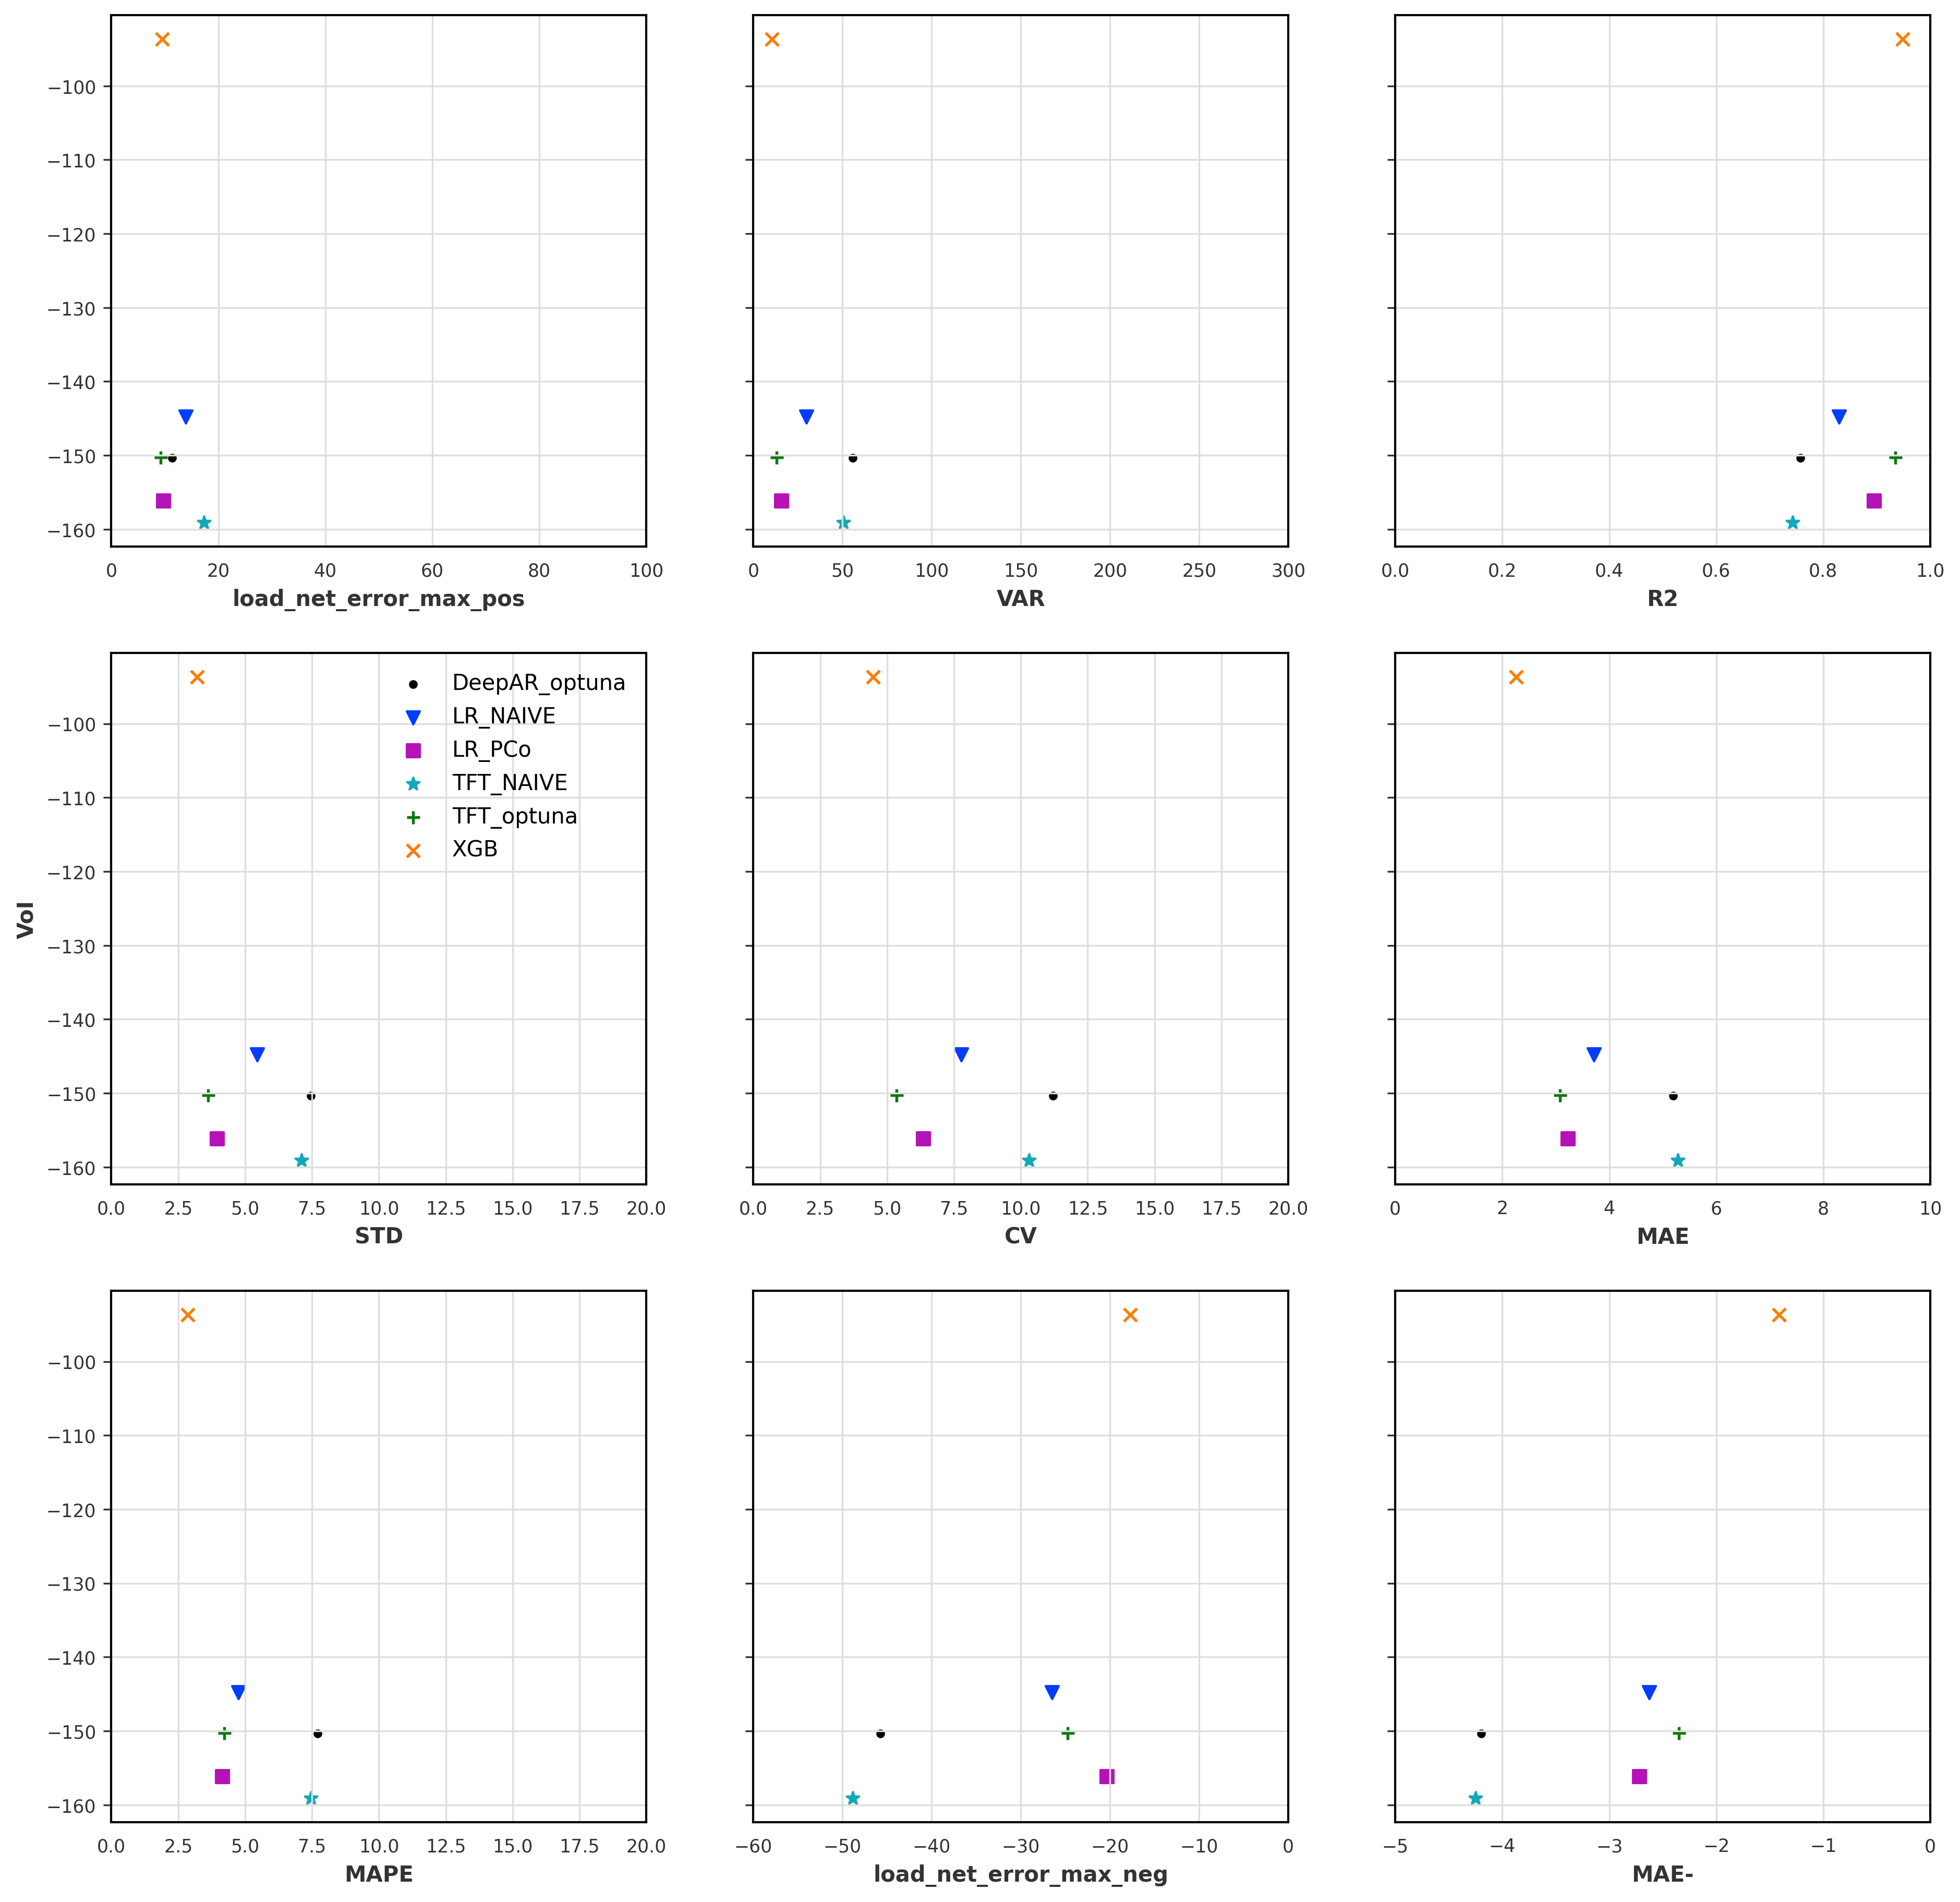

In [72]:
import matplotlib.pyplot as plt
#import numpy as np
#import matplotlib.gridspec as gridspec

'''fig = plt.figure(figsize=(18, 18))  # 创建画布
grid = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],height_ratios=[1,1,1])  
grid.update(wspace =0.16, hspace = 0.18)'''

fig,axs=plt.subplots(3,3,figsize=(15,15),sharex=False,sharey=True)


method_dic=[
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

marker_dic={
    "DeepAR_optuna":'.',
    "LR_NAIVE":'v',
    "LR_PCo":'s',
    "TFT_NAIVE":'*',
    "TFT_optuna":'+',
    "XGB":'x',
    'load_net_error_max_neg':'o',
    'load_net_error_max_pos':'o',
}
xlimit={
    'CV':[0,20],
    'MAE':[0,10],
    'MAE+':[0,5],
    'MAE-':[-5,0],
    'MAPE':[0,20],
    'OPE':[0,10],
    'RMSE':[0,20],
    'STD':[0,20],
    'VAR':[0,300],
    'MSE':[0,20],
    'MARRE':[0,15],
    'R2':[0,1],
    'SMAPE':[0,15],
    'load_net_error_max_neg':[-60,0],
    'load_net_error_max_pos':[0,100],
}

metrics_keys={
    'CV',
    'MAE',
    'MAPE',
    #'OPE',
    'VAR',
    'MAE-',
    #'RMSE',
    'STD',
    #'MSE',
    #'MARRE',
    'R2',
    #'SMAPE',
    'load_net_error_max_neg',
    'load_net_error_max_pos',
}

total_df_0dc=total_df[(total_df.price_dc==0) & (total_df.month_of_year==4)]
total_df_dc=total_df[(total_df.price_dc==0.6) & (total_df.month_of_year==4)]

#total_df_0dc=total_df[(total_df.price_dc==0) ]
#total_df_dc=total_df[(total_df.price_dc==0.6) ]

df_to_plot=total_df_dc
key_to_plot='VoI'
i,j=0,0
for metric in metrics_keys:
    ax=axs[i,j] # 第二行，第3列

    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        ax.scatter(X,Y,label=method,marker=marker_dic[method])
        ax.set_xlim(xlimit[metric])
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlabel(metric)
    if i==1 and j==0:
        ax.set_ylabel(key_to_plot)
        ax.legend()
    if i<2:
        i+=1
    else:
        i=0
        j+=1
        
#plt.suptitle(0.5,0.85,"Metrics and relative_OPEX (dc=0)",)

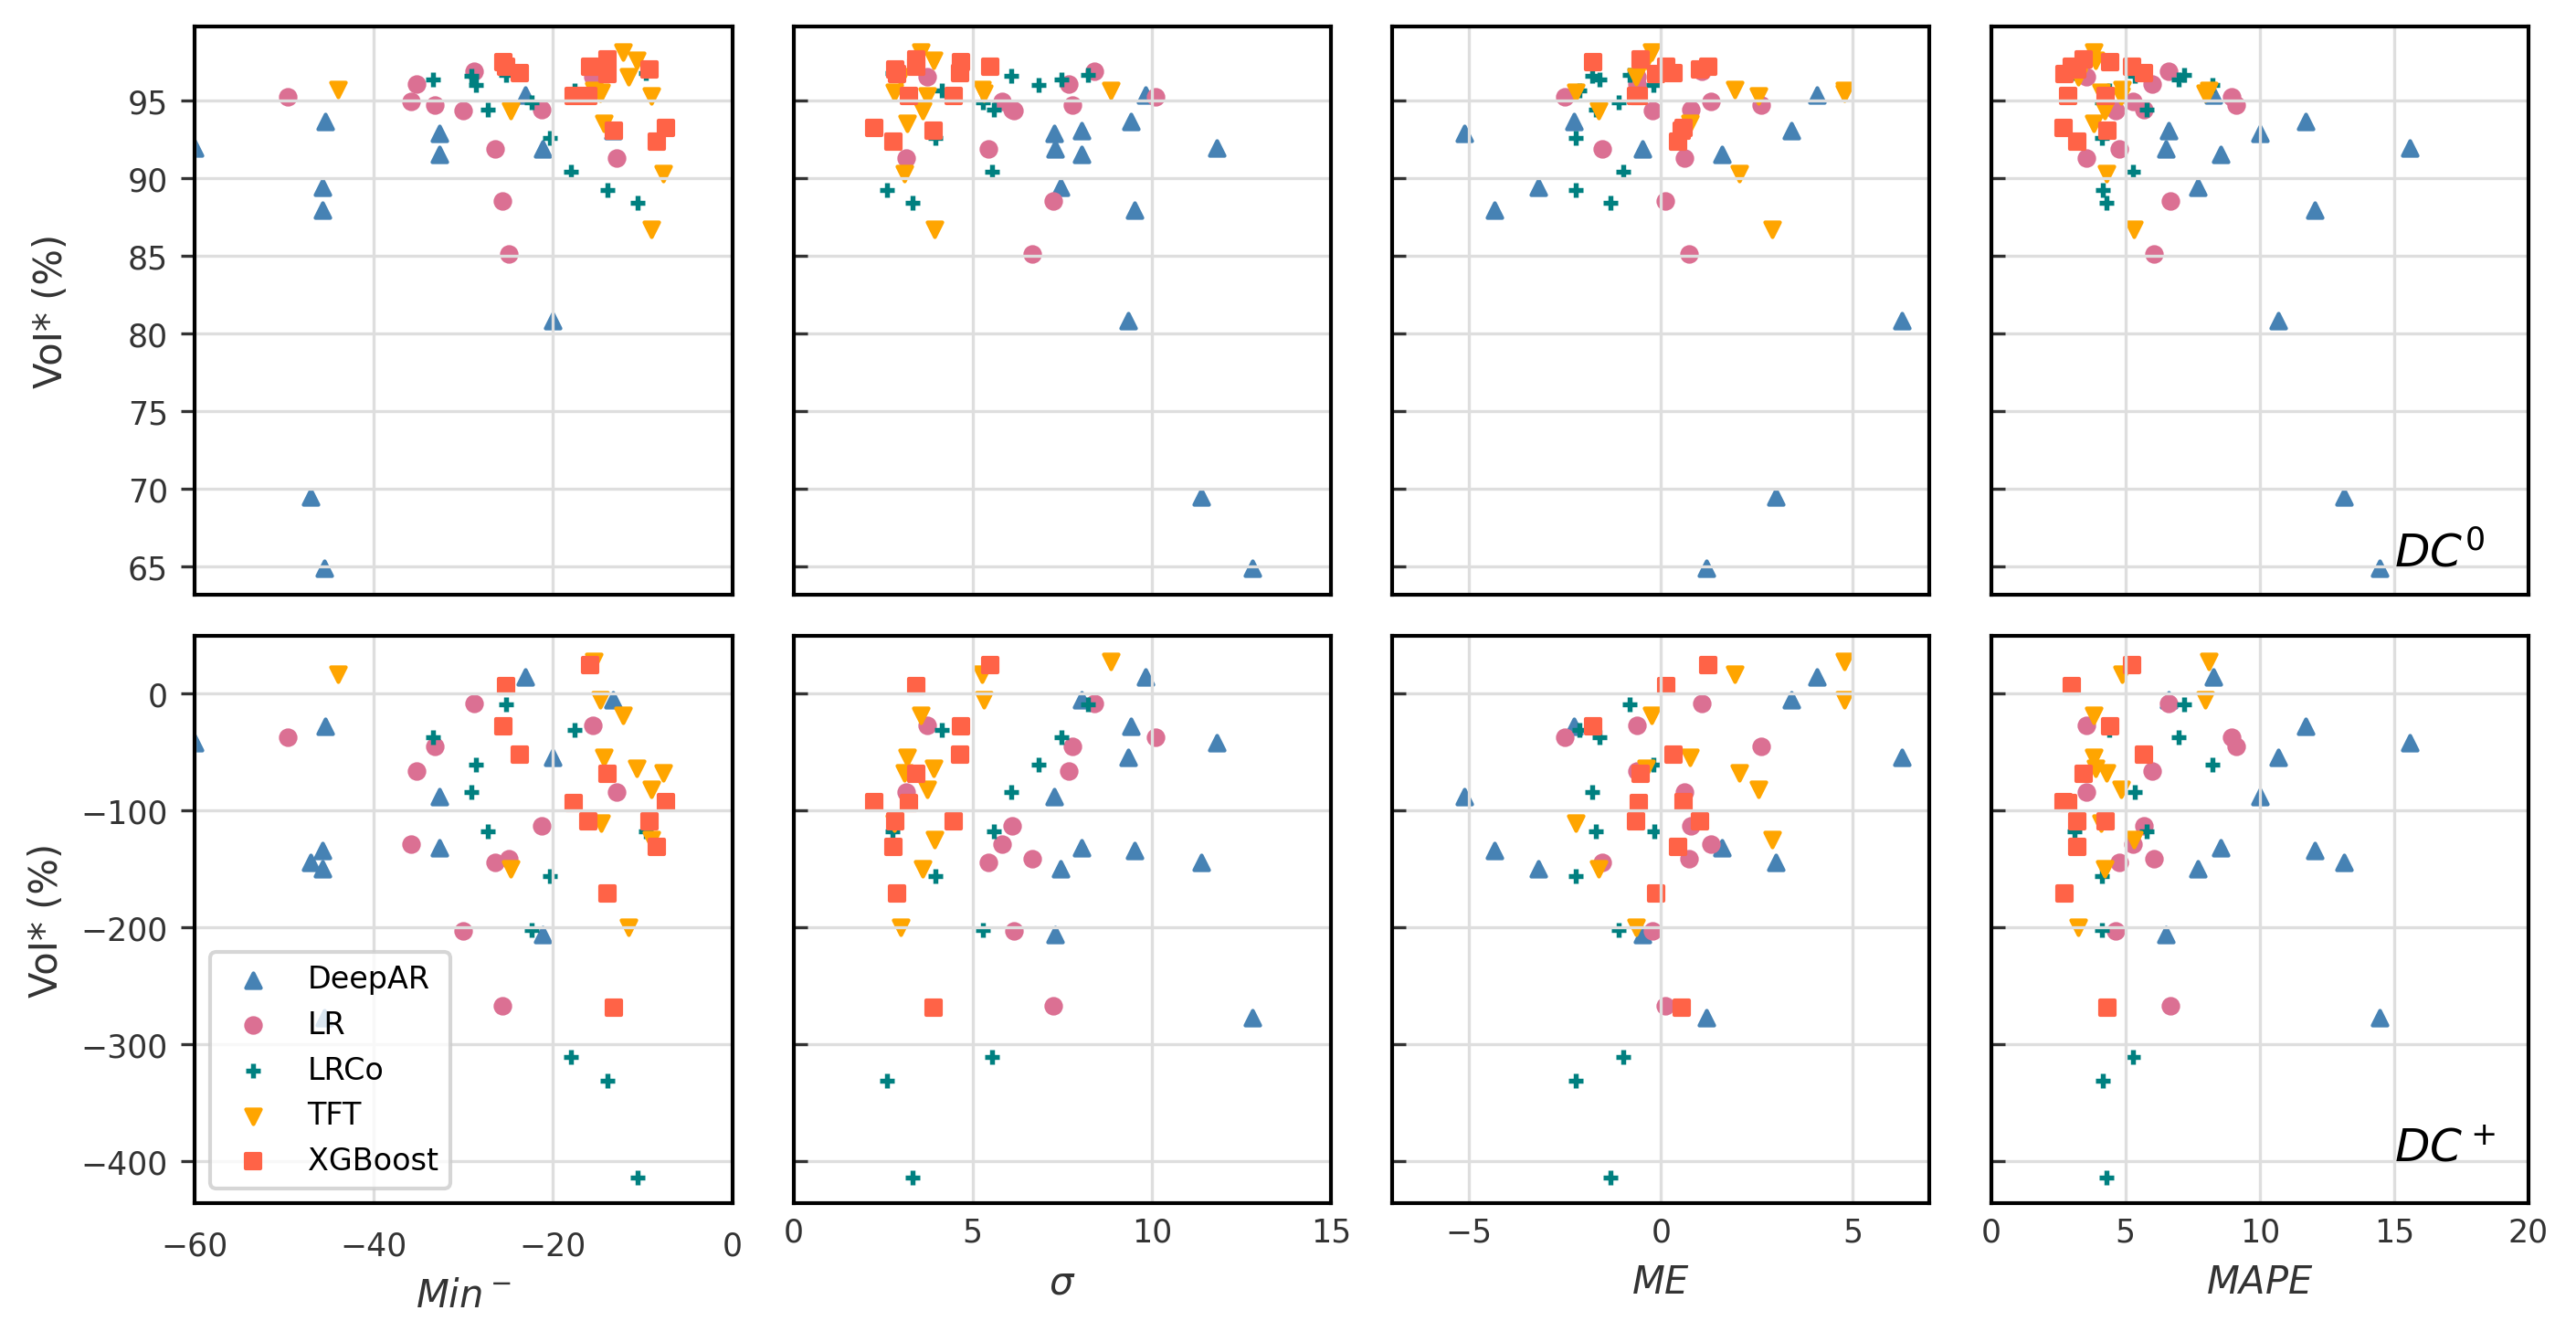

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

'''fig = plt.figure(figsize=(18, 18))  # 创建画布
grid = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],height_ratios=[1,1,1])  
grid.update(wspace =0.16, hspace = 0.18)'''

fig,axs=plt.subplots(2,4,figsize=(9.5,5),sharex=False,sharey=False, squeeze=True)


method_dic=[
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    #"TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

color_dic={
    "DeepAR_optuna":'teal',
    "LR_NAIVE":'darkorange',
    "LR_PCo":'powderblue',
    #"TFT_NAIVE":'*',
    "TFT_optuna":'blueviolet',
    "XGB":'gold'
}

label_dic={
    "DeepAR_optuna":'DeepAR',
    "LR_NAIVE":'LR',
    "LR_PCo":'LRCo',
    #"TFT_NAIVE":'*',
    "TFT_optuna":'TFT',
    "XGB":'XGBoost',
    'load_net_error_max_neg':'$Min^-$',
    'MAPE':'$MAPE$',
    'STD':'$\sigma$',
    'MAE-':'$ME^-$',
    'ME':'$ME$',
    
}
marker_dic={
    "DeepAR_optuna":'^',
    "LR_NAIVE":'o',
    "LR_PCo":'+',
    "TFT_optuna":'v',
    "XGB":'s',
}
xlimit={
    'CV':[0,20],
    'MAE':[0,10],
    'MAE+':[0,5],
    'MAE-':[-5,0],
    'MAPE':[0,20],
    'OPE':[0,10],
    'RMSE':[0,20],
    'STD':[0,15],
    'VAR':[0,300],
    'MSE':[0,20],
    'MARRE':[0,15],
    'ME':[-7,7],
    'R2':[0,1],
    'SMAPE':[0,15],
    'load_net_error_max_neg':[-60,0],
    'load_net_error_max_pos':[0,100],
}

metrics_keys={
    #'CV',
    #'MAE',
    'MAPE',
    #'OPE',
    #'VAR',
    #'MAE-',
    #'RMSE',
    'ME',
    'STD',
    #'MSE',
    #'MARRE',
    #'R2',
    #'SMAPE',
    'load_net_error_max_neg',
    #'load_net_error_max_pos',
}

total_df_0dc=total_df[(total_df.price_dc==0) & (total_df.month_of_year==4)]
total_df_dc=total_df[(total_df.price_dc==0.6) & (total_df.month_of_year==4)]

total_df_0dc=total_df[(total_df.price_dc==0) ]
total_df_dc=total_df[(total_df.price_dc==0.6) ]

#########################################################################################################
df_to_plot=total_df_0dc
key_to_plot='VoI'
i,j=0,0
for metric in metrics_keys:
    ax=axs[0,i] # 第二行，第3列
    x_values = []
    y_values = []
    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        x_values.extend(list(X))
        y_values.extend(list(Y))
        ax.scatter(X,Y,marker=marker_dic[method],color=color_dic_glb[method],label=label_dic[method],s=15)
        ax.set_xlim(xlimit[metric])
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    regressor = LinearRegression()
    x_values = np.array(x_values).reshape(-1, 1)  # Reshape to meet sklearn's input requirements
    regressor.fit(x_values, y_values)

    # Predict values using the linear regression model
    y_pred = regressor.predict(x_values)
    #ax.plot(x_values, y_pred, color='red', linewidth=2, label='Regression Line')
    #ax.set_xlabel(metric,weight='regular')
    if i==0 :
        ax.set_ylabel('VoI* (%)',weight='light',labelpad=15)
        #ax.legend(fontsize=8,loc='lower right',facecolor='w',frameon=True)
    else:
        ax.set_yticklabels([])
        ax.tick_params(direction='in',axis='both')
    ax.set_xticklabels([])
    i+=1
    if i>=5:
        break
#########################################################################################################  
    
df_to_plot=total_df_dc
key_to_plot='VoI'
i,j=0,0
for metric in metrics_keys:
    ax=axs[1,i] # 第二行，第3列
    x_values = []
    y_values = []
    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        x_values.extend(list(X))
        y_values.extend(list(Y))
        ax.scatter(X,Y,marker=marker_dic[method],color=color_dic_glb[method],label=label_dic[method],s=15)
        ax.set_xlim(xlimit[metric])
        
    regressor = LinearRegression()
    x_values = np.array(x_values).reshape(-1, 1)  # Reshape to meet sklearn's input requirements
    regressor.fit(x_values, y_values)

    # Predict values using the linear regression model
    y_pred = regressor.predict(x_values)

    # Plot the regression line
    #ax.plot(x_values, y_pred, color='red', linewidth=2, label='Regression Line')
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlabel(label_dic[metric],weight='bold')
    if i==0 :
        ax.set_ylabel('VoI* (%)',weight='light')
        ax.legend(fontsize=8,loc='lower left',facecolor='w',frameon=True)
    else:
        ax.set_yticklabels([])
        ax.tick_params(direction='in',axis='both')
    i+=1
    if i>=5:
        break
    
axs[0,3].text(s='$DC^0$',x=15,y=65,fontsize=12)
axs[1,3].text(s='$DC^+$',x=15,y=-400,fontsize=12)
    
plt.tight_layout()

#plt.suptitle(0.5,0.85,"Metrics and relative_OPEX (dc=0)",)

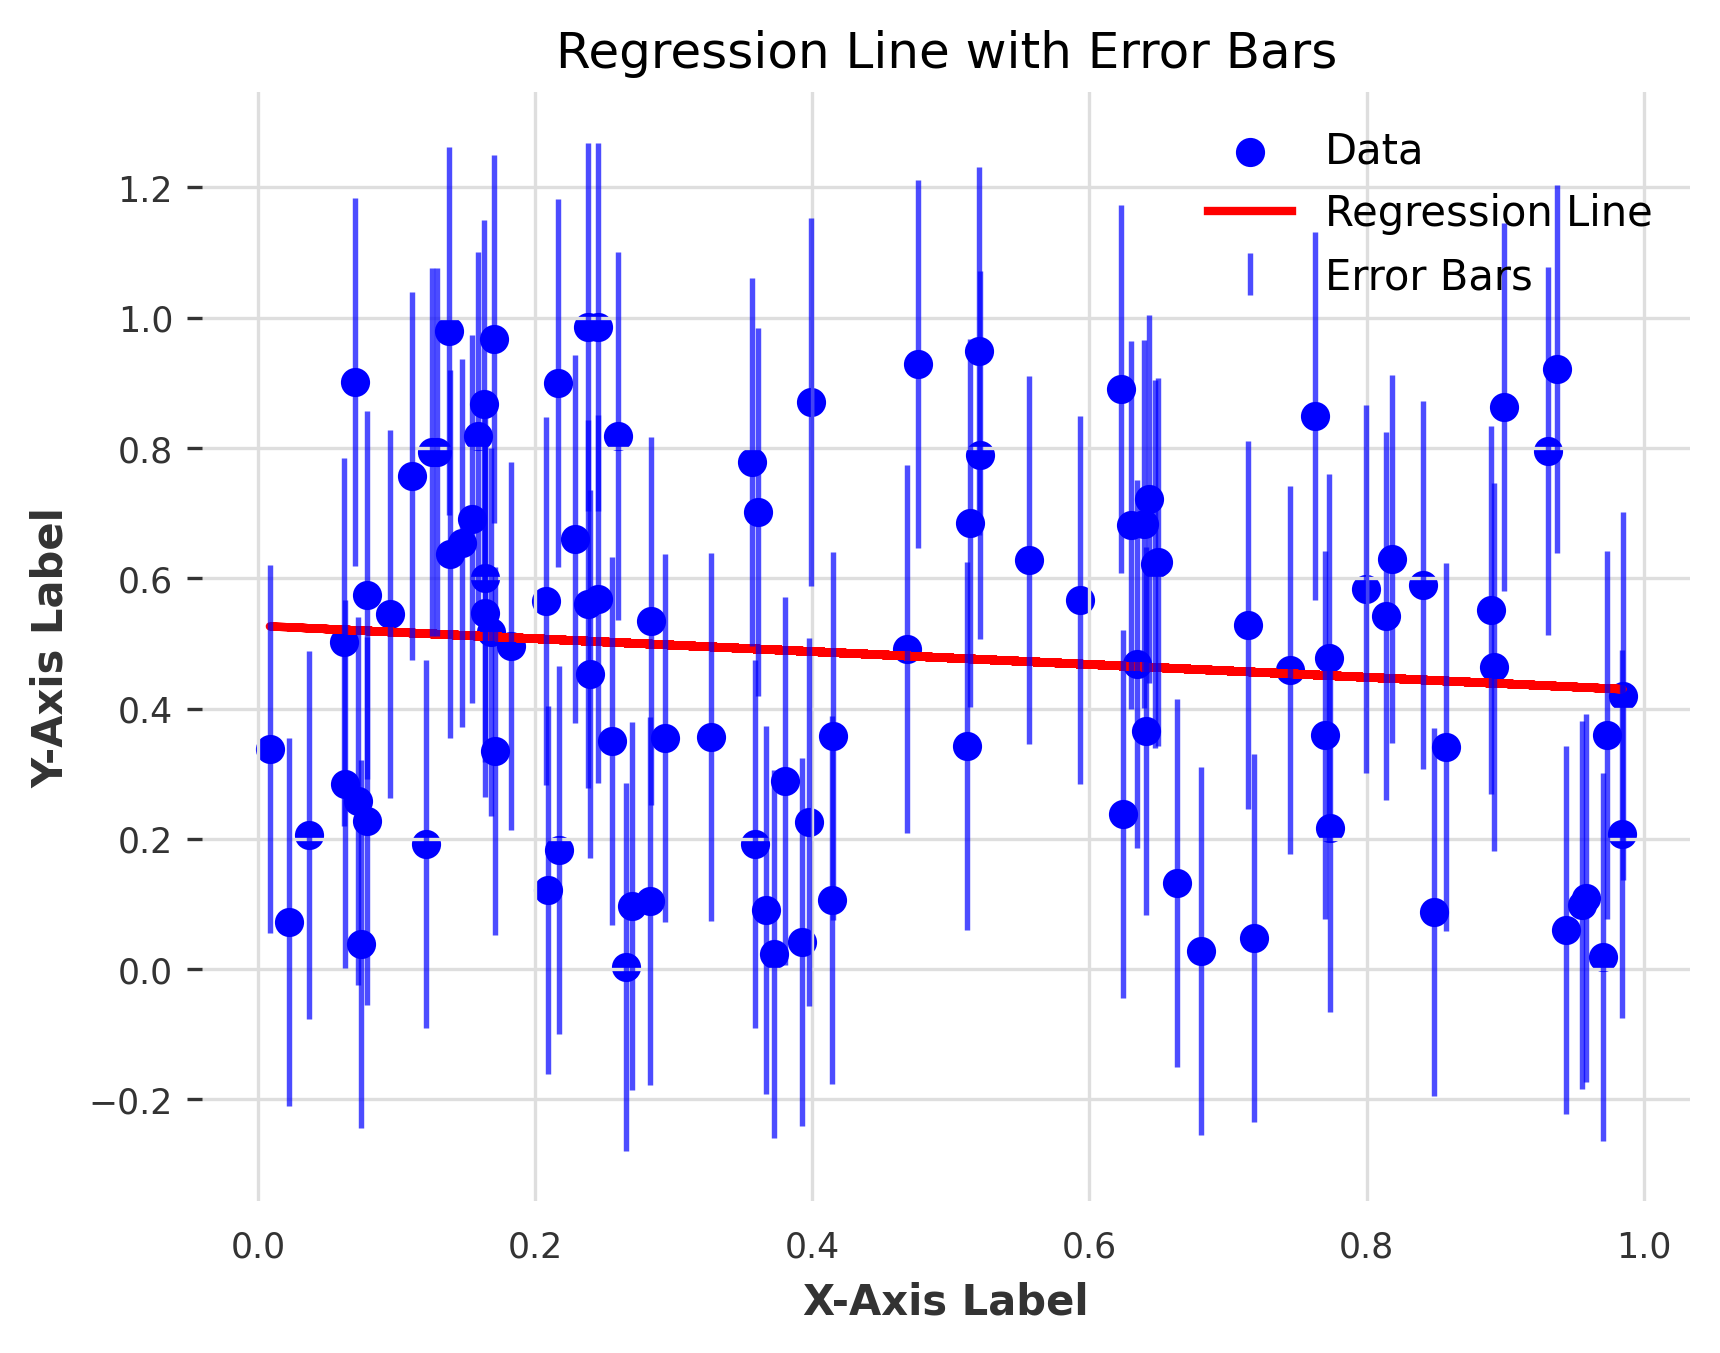

Standard Deviation of Residuals: 0.28
Mean Squared Error (MSE): 0.08


In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate example data
x_data = np.random.rand(100)  # Example: Random x-values
y_data = np.random.rand(100) 

# Fit a linear regression model to the data
regressor = LinearRegression()
x_data = x_data.reshape(-1, 1)  # Reshape to meet sklearn's input requirements
regressor.fit(x_data, y_data)

# Predict values using the linear regression model
y_pred = regressor.predict(x_data)

# Calculate the residuals (errors)
residuals = y_data - y_pred

# Calculate the standard deviation of the residuals
residual_std = np.std(residuals)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_data, y_pred)

# Create a scatter plot of the data points
plt.scatter(x_data, y_data, label='Data', color='blue')

# Plot the regression line
plt.plot(x_data, y_pred, color='red', linewidth=2, label='Regression Line')

# Add error bars to the data points
plt.errorbar(x_data, y_data, yerr=residual_std, linestyle='None', color='blue', alpha=0.7, label='Error Bars')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Regression Line with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

print(f"Standard Deviation of Residuals: {residual_std:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")


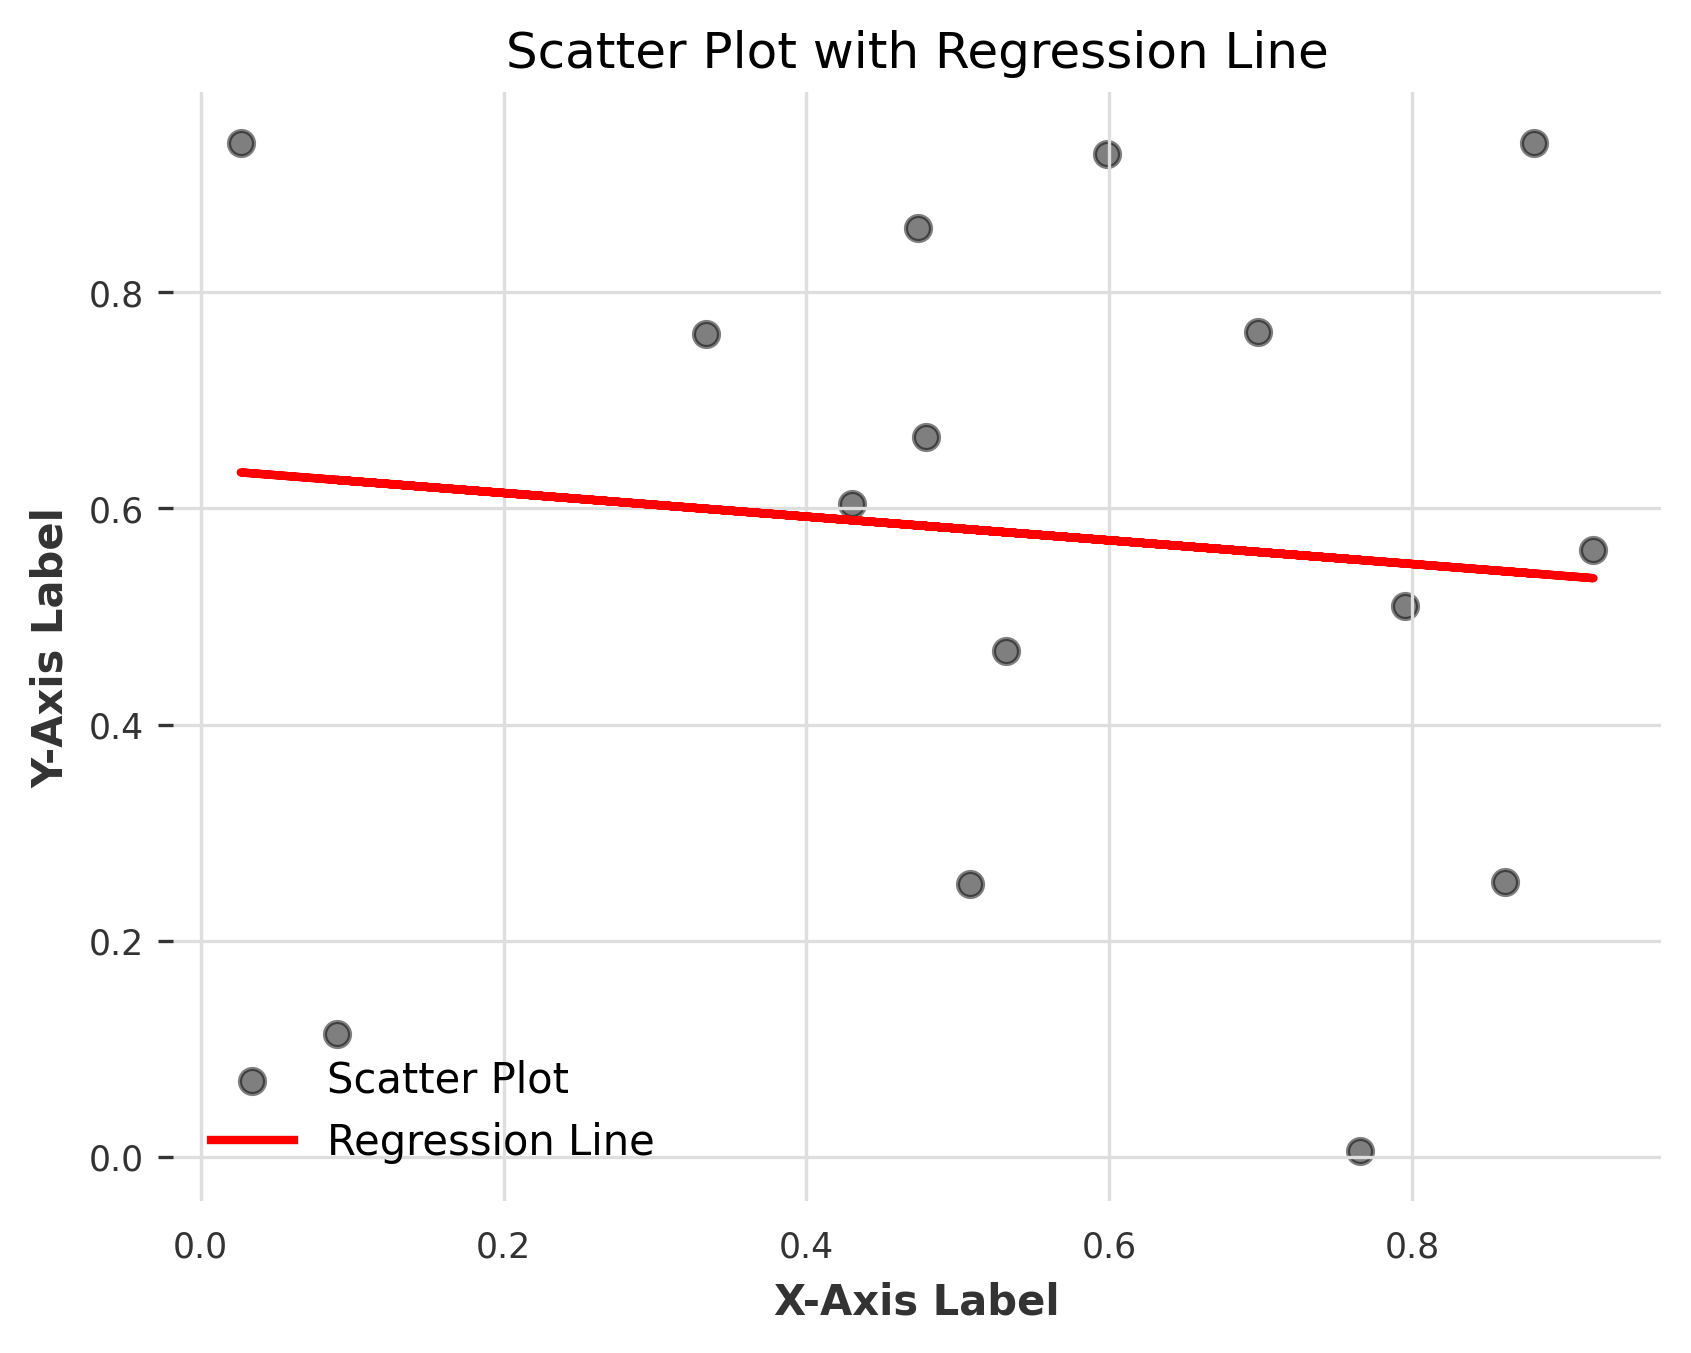

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Create empty lists to store data points
x_values = []
y_values = []

# Define the number of scatter plots and data points
num_scatter_plots = 3
num_data_points = 5

# Create scatter plots in a for loop and collect data points
for i in range(num_scatter_plots):
    x_data = np.random.rand(num_data_points)  # Example: Random x-values
    y_data = np.random.rand(num_data_points)  # Example: Random y-values

    # Append data points to the lists
    x_values.extend(x_data)
    y_values.extend(y_data)

# Create a scatter plot with the collected data
plt.scatter(x_values, y_values, label='Scatter Plot', alpha=0.5)

# Fit a linear regression model to the combined data
regressor = LinearRegression()
x_values = np.array(x_values).reshape(-1, 1)  # Reshape to meet sklearn's input requirements
regressor.fit(x_values, y_values)

# Predict values using the linear regression model
y_pred = regressor.predict(x_values)

# Plot the regression line
plt.plot(x_values, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel('X-Axis Label')
plt.ylabel('Y-Axis Label')
plt.title('Scatter Plot with Regression Line')
plt.legend()
plt.show()

